In [ ]:


import os, sys, math, json, glob, random, time, collections, subprocess
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.cuda.amp import GradScaler, autocast

import jiwer  # WER/CER
from einops import rearrange

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

if torch.cuda.is_available():
    try:
        gpu_info = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=name,memory.total", "--format=csv,noheader"]
        ).decode().strip()
        print("GPU info:", gpu_info)
    except Exception as e:
        print("Could not get GPU info:", e)

Torch: 2.3.1+cu121
CUDA available: True
Using device: cuda
GPU info: NVIDIA A100-SXM4-40GB, 40960 MiB


In [ ]:


DEFAULT_INPUT = "/content/cs769projectTeam3/data"
ALTERNATE_INPUT = "/content/cs769projectTeam3/data"

INPUT_DIR = Path(DEFAULT_INPUT) if Path(DEFAULT_INPUT).exists() else Path(ALTERNATE_INPUT)
assert INPUT_DIR.exists(), f"Input not found. Set INPUT_DIR to your dataset root. Tried: {INPUT_DIR}"

SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Training config
BATCH_SIZE = 8          # will be overridden in Block 4
NUM_WORKERS = 2         # will be overridden in Block 4
EPOCHS = 15
LR = 5e-4

# Vocabulary: 0 is CTC blank
BLANK_ID = 0



In [ ]:

def index_split_files(root: Path):
    split_map = {"train": [], "val": [], "test": []}
    for fp in root.rglob("data_*.hdf5"):
        name = fp.name
        if "data_train" in name:
            split_map["train"].append(fp)
        elif "data_val" in name:
            split_map["val"].append(fp)
        elif "data_test" in name:
            split_map["test"].append(fp)
    for k in split_map:
        split_map[k] = sorted(split_map[k])
    return split_map

def list_trials(h5_path: Path):
    trials = []
    with h5py.File(h5_path, "r") as hf:
        for k in hf.keys():
            g = hf[k]
            if "input_features" in g and "transcription" in g:
                trials.append(k)
    return trials

def build_index(file_list):
    rows = []
    for fp in file_list:
        with h5py.File(fp, "r") as hf:
            for k in hf.keys():
                g = hf[k]
                if "input_features" in g and "transcription" in g:
                    rows.append({"file": str(fp), "trial": k})
    return pd.DataFrame(rows)

# Inspect files
hdf5_files = sorted(INPUT_DIR.rglob("*.hdf5"))
print(f"Found {len(hdf5_files)} .hdf5 files")
assert len(hdf5_files) > 0, "No .hdf5 files found in INPUT_DIR"

sample_file = hdf5_files[0]
print("Sample file:", sample_file.relative_to(INPUT_DIR))
with h5py.File(sample_file, "r") as hf:
    keys = list(hf.keys())
    print("Top-level keys sample:", keys[:5], f"(total {len(keys)})")
    if keys:
        g0 = keys[0]
        print("Example group:", g0, "->", list(hf[g0].keys()))

# Build splits
split_files = index_split_files(INPUT_DIR)
print({k: len(v) for k, v in split_files.items()})

train_df = build_index(split_files["train"])
val_df   = build_index(split_files["val"]) if split_files["val"] else build_index(split_files["test"])

print("Train trials:", len(train_df), "Val trials:", len(val_df))
display(train_df.head(3))

Found 127 .hdf5 files
Sample file: hdf5_data_final/t15.2023.08.11/data_train.hdf5
Top-level keys sample: ['trial_0000', 'trial_0001', 'trial_0002', 'trial_0003', 'trial_0004'] (total 288)
Example group: trial_0000 -> ['input_features', 'seq_class_ids', 'transcription']
{'train': 45, 'val': 41, 'test': 41}
Train trials: 8072 Val trials: 1426


KeyError: 'In'

,file,trial
0,/content/cs769projectTeam3/data/hdf5_data_fina...,trial_0000
1,/content/cs769projectTeam3/data/hdf5_data_fina...,trial_0001
2,/content/cs769projectTeam3/data/hdf5_data_fina...,trial_0002


In [ ]:

import re
from tqdm import tqdm

def _discover_charset_from_ascii(h5_paths):
    """Build charset from ASCII-encoded transcriptions"""
    vocab_set = set()

    print("Scanning transcriptions for ASCII characters...")
    for fp in tqdm(h5_paths[:10], desc="Scanning files"):
        try:
            with h5py.File(fp, "r") as hf:
                trial_keys = list(hf.keys())[:100]
                for trial_key in trial_keys:
                    if "transcription" in hf[trial_key]:
                        trans = hf[trial_key]["transcription"][()]
                        # These are ASCII codes, not indices
                        ascii_codes = trans[trans != 0]
                        vocab_set.update(ascii_codes)
        except Exception as e:
            print(f"Error reading {fp}: {e}")
            continue

    if not vocab_set:
        print("⚠ No vocab found!")
        return ["<blank>"] + [chr(i) for i in range(32, 127)]

    # Build charset: blank + sorted ASCII characters
    unique_codes = sorted(vocab_set)
    charset = ["<blank>"]

    print(f"\n✓ Found {len(unique_codes)} unique ASCII codes")
    print(f"   Range: {min(unique_codes)} to {max(unique_codes)}")

    # Map ASCII code -> index in charset
    ascii_to_idx = {0: 0}  # blank
    for idx, code in enumerate(unique_codes, start=1):
        char = chr(code)
        charset.append(char)
        ascii_to_idx[code] = idx

    print(f"✓ Charset size: {len(charset)}")
    print(f"   Sample chars: {charset[1:20]}")

    return charset, ascii_to_idx

# Discover vocabulary
_CHARSET, ASCII_TO_IDX = _discover_charset_from_ascii(sorted(INPUT_DIR.rglob("data_*.hdf5")))
VOCAB_SIZE = len(_CHARSET)
print(f"\n✓ Final vocabulary size: {VOCAB_SIZE} | BLANK_ID={BLANK_ID}")

def ids_to_text(id_list):
    """Convert token IDs to text"""
    out = []
    for i in id_list:
        if 0 <= i < len(_CHARSET) and i != BLANK_ID:
            out.append(_CHARSET[i])
    text = "".join(out)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def ascii_to_indices(ascii_array):
    """Convert ASCII codes to vocab indices"""
    indices = []
    for code in ascii_array:
        if code == 0:
            continue  # Skip padding
        indices.append(ASCII_TO_IDX.get(int(code), 0))  # 0 if unknown
    return indices

Scanning transcriptions for ASCII characters...


Scanning files: 100%|██████████| 10/10 [00:00<00:00, 39.22it/s]


✓ Found 55 unique ASCII codes
   Range: 32 to 122
✓ Charset size: 56
   Sample chars: [' ', '!', "'", ',', '.', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N']

✓ Final vocabulary size: 56 | BLANK_ID=0


In [ ]:

class BrainDatasetFixed(Dataset):
    """Dataset with ASCII to index conversion"""
    def __init__(self, df: pd.DataFrame, norm_stats=None, compute_stats=False):
        self.df = df.reset_index(drop=True)
        self.norm_stats = norm_stats

        if compute_stats and norm_stats is None:
            print("Computing global normalization statistics...")
            self.norm_stats = self._compute_global_stats()

    def _compute_global_stats(self):
        all_means, all_stds = [], []
        n_samples = min(200, len(self.df))

        for idx in tqdm(range(n_samples), desc="Computing stats"):
            row = self.df.iloc[idx]
            try:
                with h5py.File(row["file"], "r") as hf:
                    x = hf[row["trial"]]["input_features"][()]
                    all_means.append(x.mean(axis=0))
                    all_stds.append(x.std(axis=0))
            except Exception:
                continue

        if not all_means:
            return None

        global_mean = np.mean(all_means, axis=0)
        global_std = np.mean(all_stds, axis=0)
        print(f"✓ Stats computed from {len(all_means)} samples")
        return {"mean": global_mean, "std": global_std}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fp = row["file"]; trial = row["trial"]
        with h5py.File(fp, "r") as hf:
            g = hf[trial]
            x = g["input_features"][()]
            y_ascii = g["transcription"][()]  # ASCII codes!

        # Convert ASCII codes to vocab indices
        y_ascii_clean = y_ascii[y_ascii != 0]
        y = ascii_to_indices(y_ascii_clean)

        # Normalize
        if self.norm_stats is not None:
            x = (x - self.norm_stats["mean"]) / (self.norm_stats["std"] + 1e-5)
        else:
            x = (x - x.mean(axis=0, keepdims=True)) / (x.std(axis=0, keepdims=True) + 1e-5)

        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        return x, y

In [ ]:

# Create train dataset with stats computation
train_dataset = BrainDatasetFixed(train_df, compute_stats=True)

# Create val dataset using train stats
val_dataset = BrainDatasetFixed(val_df, norm_stats=train_dataset.norm_stats)

# High-throughput loaders
n_gpus = torch.cuda.device_count() if torch.cuda.is_available() else 1
BATCH_SIZE = 96 if n_gpus == 1 else 96 * n_gpus
NUM_WORKERS = min(os.cpu_count(), 16)
PREFETCH = 4

print(f"\n🚀 GPUs: {n_gpus} | Batch Size: {BATCH_SIZE} | Workers: {NUM_WORKERS}")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    prefetch_factor=PREFETCH,
    pin_memory=True,
    persistent_workers=True,
    drop_last=True,
    collate_fn=collate_train
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    prefetch_factor=PREFETCH,
    pin_memory=True,
    persistent_workers=True,
    drop_last=False,
    collate_fn=collate_val
)

bx, bt, blx, blt = next(iter(train_loader))
print(f"\n✓ Batch check - x: {bx.shape}, targets: {bt.shape}")
IN_CH = bx.shape[1]
print(f"✓ Input channels: {IN_CH}")

Computing global normalization statistics...


Computing stats: 100%|██████████| 200/200 [00:01<00:00, 197.40it/s]


✓ Stats computed from 200 samples

🚀 GPUs: 1 | Batch Size: 96 | Workers: 12

✓ Batch check - x: torch.Size([96, 512, 1569]), targets: torch.Size([2793])
✓ Input channels: 512


In [ ]:

@torch.no_grad()
def greedy_decode_from_logprobs(log_probs, blank=0):
    """Greedy CTC decoding"""
    preds = log_probs.argmax(-1).cpu().numpy()
    decoded = []
    for i in range(preds.shape[0]):
        seq = preds[i]
        seq_clean = [p for j, p in enumerate(seq) if (j == 0 or p != seq[j-1]) and p != blank]
        decoded.append(seq_clean)
    return decoded

def ctc_beam_search(log_probs, beam_size=10, blank_id=0):
    """CTC beam search decoding"""
    T, V = log_probs.shape
    log_probs = log_probs.cpu().numpy()
    beams = {(): (0.0, -np.inf)}
    for t in range(T):
        next_beams = {}
        for prefix, (p_b, p_nb) in beams.items():
            nb = next_beams.get(prefix, (-np.inf, -np.inf))
            next_beams[prefix] = (
                np.logaddexp(nb[0], p_b + log_probs[t, blank_id]),
                np.logaddexp(nb[1], p_nb + log_probs[t, blank_id])
            )
            for c in range(V):
                if c == blank_id:
                    continue
                new_prefix = prefix + (c,) if (len(prefix) == 0 or c != prefix[-1]) else prefix
                p = p_b + log_probs[t, c] if (len(prefix)==0 or c != prefix[-1]) else p_nb + log_probs[t, c]
                nb = next_beams.get(new_prefix, (-np.inf, -np.inf))
                next_beams[new_prefix] = (nb[0], np.logaddexp(nb[1], p))
        beams = dict(sorted(next_beams.items(),
                            key=lambda kv: np.logaddexp(kv[1][0], kv[1][1]),
                            reverse=True)[:beam_size])
    best = max(beams.items(), key=lambda kv: np.logaddexp(kv[1][0], kv[1][1]))[0]
    return list(best)

In [ ]:

class Swish(nn.Module):
    def forward(self, x):
        return F.silu(x)

class FeedForwardModule(nn.Module):
    def __init__(self, d_model, ff_mult=4, pdrop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model * ff_mult),
            Swish(),
            nn.Dropout(pdrop),
            nn.Linear(d_model * ff_mult, d_model),
            nn.Dropout(pdrop),
        )
    def forward(self, x):
        return self.net(x)

class MHSA(nn.Module):
    def __init__(self, d_model, nhead=8, pdrop=0.1):
        super().__init__()
        self.ln = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, nhead, dropout=pdrop, batch_first=True)
        self.dropout = nn.Dropout(pdrop)
    def forward(self, x, key_padding_mask=None):
        x0 = self.ln(x)
        y, _ = self.attn(x0, x0, x0, key_padding_mask=key_padding_mask, need_weights=False)
        return x + self.dropout(y)

class ConvModule(nn.Module):
    def __init__(self, d_model, kernel_size=31, pdrop=0.1):
        super().__init__()
        self.ln = nn.LayerNorm(d_model)
        self.pw1 = nn.Conv1d(d_model, 2*d_model, kernel_size=1, stride=1, padding=0)
        self.dw = nn.Conv1d(d_model, d_model, kernel_size=kernel_size, stride=1,
                            padding=kernel_size//2, groups=d_model)
        self.bn = nn.BatchNorm1d(d_model)
        self.act = Swish()
        self.pw2 = nn.Conv1d(d_model, d_model, kernel_size=1, stride=1, padding=0)
        self.dropout = nn.Dropout(pdrop)

    def forward(self, x):
        y = self.ln(x)
        y = y.transpose(1, 2)
        y = self.pw1(y)
        y = F.glu(y, dim=1)
        y = self.dw(y)
        y = self.bn(y)
        y = self.act(y)
        y = self.pw2(y)
        y = y.transpose(1, 2)
        return x + self.dropout(y)

class ConformerBlock(nn.Module):
    def __init__(self, d_model, nhead=8, ff_mult=4, kernel_size=31, pdrop=0.1):
        super().__init__()
        self.ff1 = FeedForwardModule(d_model, ff_mult, pdrop)
        self.mhsa = MHSA(d_model, nhead, pdrop)
        self.conv = ConvModule(d_model, kernel_size, pdrop)
        self.ff2 = FeedForwardModule(d_model, ff_mult, pdrop)
        self.ln_out = nn.LayerNorm(d_model)

    def forward(self, x, key_padding_mask=None):
        x = x + 0.5 * self.ff1(x)
        x = self.mhsa(x, key_padding_mask=key_padding_mask)
        x = self.conv(x)
        x = x + 0.5 * self.ff2(x)
        return self.ln_out(x)

class SubsampleFrontend(nn.Module):
    """FIXED: Tracks output lengths after subsampling"""
    def __init__(self, in_ch, d_model):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, d_model, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv1d(d_model, d_model, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
        )
        self.ln = nn.LayerNorm(d_model)

    def forward(self, x, input_lengths=None):
        y = self.conv(x)  # [B, D, T/4]
        y = y.permute(0, 2, 1)  # [B, T/4, D]

        # Compute output lengths
        out_lengths = None
        if input_lengths is not None:
            # After two stride-2 convs with padding=2: out = (in + 2*2 - 5) / 2 + 1
            # Approximation: out ≈ in / 4
            out_lengths = ((input_lengths + 3) // 4).clamp(min=1)

        return self.ln(y), out_lengths

class ConformerEncoder(nn.Module):
    """FIXED: Propagates sequence lengths"""
    def __init__(self, in_ch, d_model=384, nhead=6, depth=12, ff_mult=4, kernel_size=31, pdrop=0.1):
        super().__init__()
        self.frontend = SubsampleFrontend(in_ch, d_model)
        self.blocks = nn.ModuleList([
            ConformerBlock(d_model, nhead=nhead, ff_mult=ff_mult, kernel_size=kernel_size, pdrop=pdrop)
            for _ in range(depth)
        ])

    def forward(self, x, input_lengths=None):
        y, out_lengths = self.frontend(x, input_lengths)
        for blk in self.blocks:
            y = blk(y)
        return y, out_lengths

In [ ]:

class ConformerCTCModel(nn.Module):
    """FIXED: Returns both logits and output lengths"""
    def __init__(self, in_ch, vocab_size,
                 d_model=384, nhead=6, depth=12, ff_mult=4, kernel_size=31, pdrop=0.1):
        super().__init__()
        self.encoder = ConformerEncoder(
            in_ch=in_ch, d_model=d_model, nhead=nhead,
            depth=depth, ff_mult=ff_mult, kernel_size=kernel_size, pdrop=pdrop
        )
        self.proj = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, vocab_size)
        )

    def forward(self, x, input_lengths=None):
        h, out_lengths = self.encoder(x, input_lengths)
        logits = self.proj(h)
        return F.log_softmax(logits, dim=-1), out_lengths

In [ ]:

def evaluate(model, loader, criterion, blank_id=0, max_batches=50, use_beam=False, beam_size=10):
    """FIXED: Uses correct output lengths"""
    model.eval()
    tot_loss, n_batches = 0.0, 0
    hyps, refs = [], []

    with torch.no_grad():
        pbar = tqdm(loader, total=min(len(loader), max_batches), desc="Validating", ncols=130)
        for b, (x, targets, x_lens, t_lens) in enumerate(pbar):
            if b >= max_batches:
                break

            x = x.to(device, non_blocking=True)
            x_lens = x_lens.to(device, non_blocking=True)

            # CRITICAL FIX: Get output lengths
            logp, output_lengths = model(x, x_lens)

            # CTC loss with correct lengths
            logp_ctc = logp.permute(1, 0, 2)
            loss = criterion(logp_ctc, targets.to(device), output_lengths, t_lens.to(device))
            tot_loss += loss.item()
            n_batches += 1

            # Decode predictions
            for i in range(logp.size(0)):
                # Use actual output length for this sample
                actual_len = int(output_lengths[i])
                lp = logp[i, :actual_len]  # Trim to actual length

                if use_beam:
                    ids = ctc_beam_search(lp, beam_size=beam_size, blank_id=blank_id)
                else:
                    ids = greedy_decode_from_logprobs(lp.unsqueeze(0), blank=blank_id)[0]

                off = int(sum(t_lens[:i]))
                L = int(t_lens[i])
                ref_ids = targets[off:off + L].tolist()
                hyps.append(ids_to_text(ids))
                refs.append(ids_to_text(ref_ids))

            pbar.set_postfix({"loss": f"{(tot_loss/n_batches):.4f}"})

    wer = jiwer.wer(refs, hyps) if refs else 0.0
    cer = jiwer.cer(refs, hyps) if refs else 0.0
    avg_loss = tot_loss / max(1, n_batches)
    return avg_loss, wer, cer

In [ ]:

torch.backends.cudnn.benchmark = True

def train_loop(model, train_loader, val_loader, epochs=15, lr=5e-4, blank_id=0,
               max_val_batches=100, grad_clip=1.0, patience=5):
    """FIXED: Uses correct output lengths and LR scheduling"""
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-2, betas=(0.9, 0.98))

    # Add cosine annealing scheduler
    total_steps = epochs * len(train_loader)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=lr/10)

    scaler = GradScaler(enabled=(device == "cuda"))
    criterion = nn.CTCLoss(blank=blank_id, zero_infinity=True)

    train_losses, val_losses, val_wers = [], [], []
    best_wer = float("inf")
    bad_epochs = 0
    best_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", ncols=130)

        for step, (x, targets, x_lens, t_lens) in enumerate(pbar, 1):
            x = x.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            t_lens = t_lens.to(device, non_blocking=True)
            x_lens = x_lens.to(device, non_blocking=True)

            with autocast(enabled=(device == "cuda")):
                # CRITICAL FIX: Pass input_lengths and get output_lengths
                logp, output_lengths = model(x, x_lens)

                logp_ctc = logp.permute(1, 0, 2)  # [T, B, V]
                loss = criterion(logp_ctc, targets, output_lengths, t_lens)

            # Check for NaN/Inf
            if not torch.isfinite(loss):
                print(f"⚠ Warning: Non-finite loss at step {step}, skipping")
                continue

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)

            running_loss += loss.item()
            current_lr = scheduler.get_last_lr()[0]
            pbar.set_postfix({"loss": f"{running_loss/step:.4f}", "lr": f"{current_lr:.2e}"})

        # Validation
        val_loss, val_wer, val_cer = evaluate(
            model, val_loader, criterion, blank_id=blank_id,
            max_batches=max_val_batches, use_beam=False
        )

        train_loss = running_loss / max(1, len(train_loader))
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_wers.append(val_wer)

        print(f"\n📊 Epoch {epoch}/{epochs}:")
        print(f"   Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"   Val WER: {val_wer:.3f} | Val CER: {val_cer:.3f}")

        # Early stopping
        if val_wer < best_wer:
            best_wer = val_wer
            bad_epochs = 0
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            print(f"   ✓ New best WER: {best_wer:.3f}")
        else:
            bad_epochs += 1
            print(f"   No improvement ({bad_epochs}/{patience})")
            if bad_epochs >= patience:
                print("   Early stopping triggered!")
                break

        torch.cuda.empty_cache()

    # Restore best model
    if best_state:
        model.load_state_dict(best_state, strict=True)
        print(f"\n✓ Restored best model (WER: {best_wer:.3f})")

    return train_losses, val_losses, val_wers




BUILDING MODEL

✓ Model: ConformerCTCModel
✓ Parameters: 10.14M
✓ Vocabulary size: 56
✓ Input channels: 512

STARTING TRAINING


Validating: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.40it/s, loss=2.8780]



📊 Epoch 1/15:
   Train Loss: 4.7726 | Val Loss: 2.8780
   Val WER: 1.000 | Val CER: 0.965
   ✓ New best WER: 1.000


Validating: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.99it/s, loss=2.2157]



📊 Epoch 2/15:
   Train Loss: 2.6167 | Val Loss: 2.2157
   Val WER: 0.975 | Val CER: 0.811
   ✓ New best WER: 0.975


Validating: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.02it/s, loss=1.6541]



📊 Epoch 3/15:
   Train Loss: 1.8094 | Val Loss: 1.6541
   Val WER: 0.818 | Val CER: 0.520
   ✓ New best WER: 0.818


Validating: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.31it/s, loss=1.3894]



📊 Epoch 4/15:
   Train Loss: 1.3282 | Val Loss: 1.3894
   Val WER: 0.742 | Val CER: 0.422
   ✓ New best WER: 0.742


Validating: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.04it/s, loss=1.2467]



📊 Epoch 5/15:
   Train Loss: 1.0554 | Val Loss: 1.2467
   Val WER: 0.692 | Val CER: 0.377
   ✓ New best WER: 0.692


Validating: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.38it/s, loss=1.2229]



📊 Epoch 6/15:
   Train Loss: 0.8591 | Val Loss: 1.2229
   Val WER: 0.655 | Val CER: 0.350
   ✓ New best WER: 0.655


Validating: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.15it/s, loss=1.1777]



📊 Epoch 7/15:
   Train Loss: 0.7076 | Val Loss: 1.1777
   Val WER: 0.635 | Val CER: 0.332
   ✓ New best WER: 0.635


Validating: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.30it/s, loss=1.1691]



📊 Epoch 8/15:
   Train Loss: 0.5858 | Val Loss: 1.1691
   Val WER: 0.609 | Val CER: 0.320
   ✓ New best WER: 0.609


Validating: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.88it/s, loss=1.2189]



📊 Epoch 9/15:
   Train Loss: 0.4829 | Val Loss: 1.2189
   Val WER: 0.604 | Val CER: 0.311
   ✓ New best WER: 0.604


Validating: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.72it/s, loss=1.2379]



📊 Epoch 10/15:
   Train Loss: 0.3999 | Val Loss: 1.2379
   Val WER: 0.599 | Val CER: 0.310
   ✓ New best WER: 0.599


Validating: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.91it/s, loss=1.2918]



📊 Epoch 11/15:
   Train Loss: 0.3292 | Val Loss: 1.2918
   Val WER: 0.595 | Val CER: 0.307
   ✓ New best WER: 0.595


Validating: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.42it/s, loss=1.3522]



📊 Epoch 12/15:
   Train Loss: 0.2789 | Val Loss: 1.3522
   Val WER: 0.591 | Val CER: 0.306
   ✓ New best WER: 0.591


Validating: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.96it/s, loss=1.4259]



📊 Epoch 13/15:
   Train Loss: 0.2405 | Val Loss: 1.4259
   Val WER: 0.585 | Val CER: 0.305
   ✓ New best WER: 0.585


Validating: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.11it/s, loss=1.4754]



📊 Epoch 14/15:
   Train Loss: 0.2174 | Val Loss: 1.4754
   Val WER: 0.586 | Val CER: 0.305
   No improvement (1/5)


Validating: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.93it/s, loss=1.5156]



📊 Epoch 15/15:
   Train Loss: 0.1980 | Val Loss: 1.5156
   Val WER: 0.589 | Val CER: 0.306
   No improvement (2/5)

✓ Restored best model (WER: 0.585)

TRAINING COMPLETE


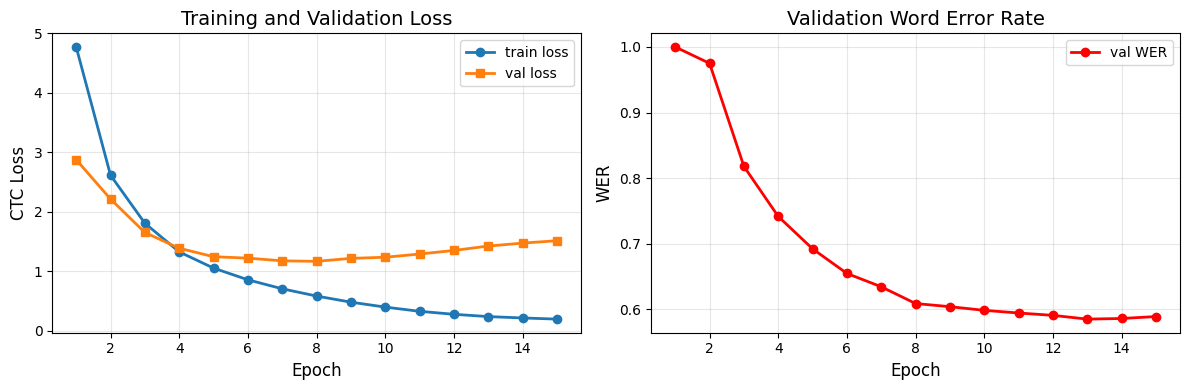


SAMPLE PREDICTIONS (Greedy Decoding)
[Sample 0]
REF: You can see the code at this point as well.
HYP: You can see the coud op this pount s wel.
[Sample 1]
REF: How does it keep the cost down?
HYP: How dus it kep the cost sone?
[Sample 2]
REF: Not too controversial.
HYP: Not do confraisil.
[Sample 3]
REF: The jury and a judge work together on it.
HYP: The creurl an a chus wak toothor on it.
[Sample 4]
REF: Were quite vocal about it.
HYP: Weu wight ferl aout it.
[Sample 5]
REF: He said the decision to part ways was mutual.
HYP: He san the decio to pourt wak was fomoral.
[Sample 6]
REF: In fact this morning when they were talking.
HYP: An vact this urging wen they were goking.
[Sample 7]
REF: This is like a cruelty joke.
HYP: This is like a carity tolk.
[Sample 8]
REF: Has such a high clay content.
HYP: Hs souft a I ling cntent.
[Sample 9]
REF: Woodworking mastery.
HYP: Wered muring mutory.
[Sample 10]
REF: Wait a minute we know this thing isn't.
HYP: Wheat a pijud we nofe sis think isse

In [ ]:

def plot_metrics(train_losses, val_losses, val_wers=None):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, marker='o', label='train loss', linewidth=2)
    plt.plot(epochs, val_losses, marker='s', label='val loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('CTC Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.title('Training and Validation Loss', fontsize=14)
    plt.grid(alpha=0.3)

    if val_wers is not None:
        plt.subplot(1,2,2)
        plt.plot(epochs, val_wers, marker='o', label='val WER', color='red', linewidth=2)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('WER', fontsize=12)
        plt.legend(fontsize=10)
        plt.title('Validation Word Error Rate', fontsize=14)
        plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


@torch.no_grad()
def preview_predictions(model, loader, n_samples=30, blank_id=0, use_beam=False):
    """Preview model predictions"""
    model.eval()
    samples_shown = 0

    for x, targets, x_lens, t_lens in loader:
        x = x.to(device)
        x_lens = x_lens.to(device)

        logp, output_lengths = model(x, x_lens)

        for i in range(x.size(0)):
            if samples_shown >= n_samples:
                return

            actual_len = int(output_lengths[i])
            lp = logp[i, :actual_len]

            if use_beam:
                hyp_ids = ctc_beam_search(lp, beam_size=10, blank_id=blank_id)
            else:
                hyp_ids = greedy_decode_from_logprobs(lp.unsqueeze(0), blank=blank_id)[0]

            off = int(sum(t_lens[:i]))
            L = int(t_lens[i])
            ref_ids = targets[off:off+L].tolist()

            hyp_text = ids_to_text(hyp_ids)
            ref_text = ids_to_text(ref_ids)

            print(f"[Sample {samples_shown}]")
            print(f"REF: {ref_text}")
            print(f"HYP: {hyp_text}")
            samples_shown += 1

        if samples_shown >= n_samples:
            break


print("\n" + "="*60)
print("BUILDING MODEL")
print("="*60)

model = ConformerCTCModel(
    in_ch=IN_CH,
    vocab_size=VOCAB_SIZE,
    d_model=256,         # Start with smaller model
    nhead=4,             # Fewer attention heads
    depth=6,             # Fewer layers to start
    ff_mult=4,
    kernel_size=31,
    pdrop=0.15           # Slightly higher dropout
)

total_params = sum(p.numel() for p in model.parameters())/1e6
print(f"\n✓ Model: {model.__class__.__name__}")
print(f"✓ Parameters: {total_params:.2f}M")
print(f"✓ Vocabulary size: {VOCAB_SIZE}")
print(f"✓ Input channels: {IN_CH}")

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

train_losses, val_losses, val_wers = train_loop(
    model, train_loader, val_loader,
    epochs=EPOCHS,
    lr=LR,
    blank_id=BLANK_ID,
    max_val_batches=50,  # Validate on 50 batches
    grad_clip=1.0,
    patience=5
)

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)

# Plot training curves
plot_metrics(train_losses, val_losses, val_wers)

print("\n" + "="*60)
print("SAMPLE PREDICTIONS (Greedy Decoding)")
print("="*60)
preview_predictions(model, val_loader, n_samples=30, blank_id=BLANK_ID, use_beam=False)


ckpt_path = "conformer_ctc_fixed.pt"
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': VOCAB_SIZE,
    'charset': _CHARSET,
    'in_ch': IN_CH,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_wers': val_wers,
}, ckpt_path)

print(f"\n✓ Model saved to: {ckpt_path}")
print(f"✓ Final WER: {val_wers[-1]:.3f}")
print(f"✓ Best WER: {min(val_wers):.3f}")